My R Notebook
============

In [1]:
# Installing pre-built packages with conda-forge
# system("conda install -qc conda-forge r-ggplot2")

In [11]:
# Load packages
library(tidyverse)
library(ggplot2)
library(knitr)



| before| after|
|------:|-----:|
|    212|   247|
|    435|   461|
|    339|   526|
|    251|   302|
|    404|   636|
|    510|   593|
|    377|   393|
|    335|   409|
|    410|   488|
|    335|   381|
|    415|   474|
|    356|   329|
|    339|   555|
|    188|   282|
|    256|   423|
|    296|   323|
|    249|   256|
|    303|   431|
|    266|   437|
|    300|   240|

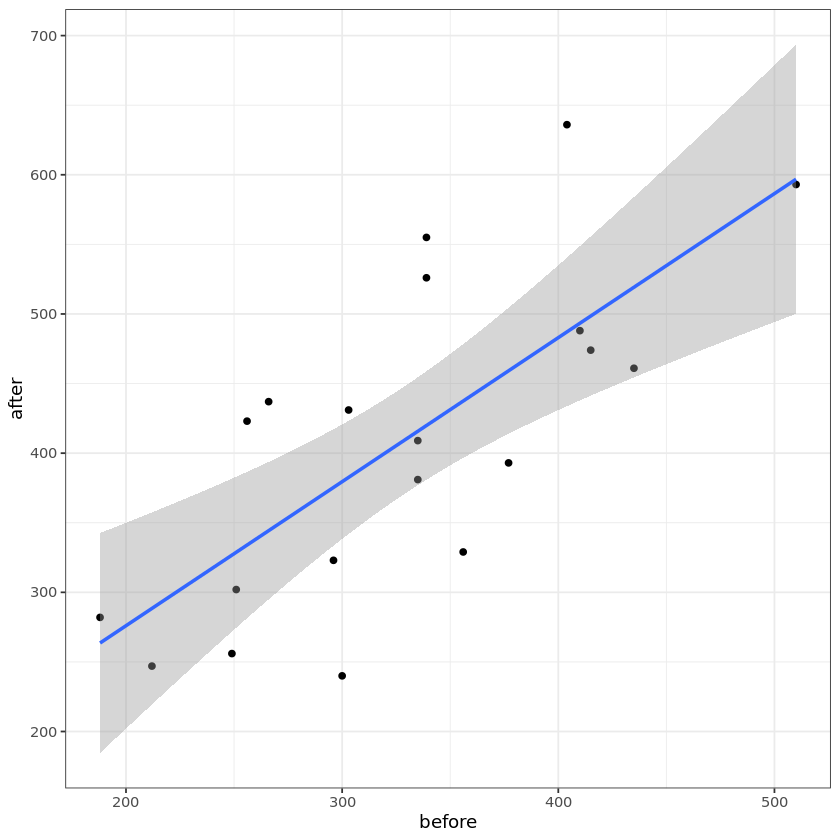

In [12]:
data1 <- read.csv("../data/data1.tsv", header=TRUE, sep = "\t", colClasses=rep("numeric",2))
data1 %>% kable()
ggplot(data1, aes(x=before,y=after)) + 
       geom_point() + 
       geom_smooth(method="lm",formula='y ~ x') + 
       theme_bw()

In [13]:
data2 <- read.csv("../data/data2.csv", header=TRUE, sep=",", 
                  colClasses=c("integer","character","numeric"))
data2 %>% kable()



| degree|gender | salary|
|------:|:------|------:|
|      0|m      |     19|
|      0|m      |     18|
|      0|m      |     21|
|      0|m      |     20|
|      0|m      |     21|
|      0|m      |     22|
|      0|m      |     19|
|      1|m      |     25|
|      1|m      |     29|
|      1|m      |     27|
|      0|f      |     15|
|      0|f      |     17|
|      0|f      |     20|
|      0|f      |     16|
|      1|f      |     24|
|      1|f      |     26|
|      1|f      |     25|
|      1|f      |     24|
|      1|f      |     27|
|      1|f      |     24|
|      1|f      |     27|
|      1|f      |     23|

In [14]:
# Fit linear model and bootstrap the regression coefficients and the ANOVA
# Load required libraries
library(lmboot)
library(bayestestR)

# Create model formula
data2$degree <- factor(data2$degree, levels = c(0,1))
data2$gender <- factor(data2$gender, levels = c('m','f'))
mdlform <- formula(salary ~ 1 + degree * gender)
lm(mdlform, data=data2)

# Fit model and bootstrap regression coefficients to obtain 95% credible intervals
mdl <- bayesian.boot(mdlform, B=4999, data=data2)
mdl$bootEstParam %>% as.data.frame() %>% hdi() %>% kable('simple')

# Fit model and bootstrap ANOVA F statistics and return p-values
aov <- ANOVA.boot(mdlform, B=4999, type="wild", wild.dist="normal", seed=NULL, data=data2, keep.boot.resp=FALSE)
rbind(aov$origFStats,aov$`p-values`) %>% t() %>% as.data.frame() %>% rename(c(F="V1",pval="V2")) %>% kable('simple')


Call:
lm(formula = mdlform, data = data2)

Coefficients:
    (Intercept)          degree1          genderf  degree1:genderf  
             20                7               -3                1  




Parameter            CI      CI_low     CI_high
----------------  -----  ----------  ----------
(Intercept)        0.95   19.129100   20.928701
degree1            0.95    5.042372    8.683303
genderf            0.95   -4.754013   -1.105568
degree1:genderf    0.95   -1.611919    3.593685



          F        pval
-----------  ----------
 87.2018182   0.0000000
 10.9661538   0.0052010
  0.4229371   0.5639128

In [15]:
# Spatial Test Data from Table 14.1 of Efron and Tibshirani (1993)
# An Introduction to the Bootstrap in Monographs on Statistics and Applied 
# Probability 57 (Springer)
# AIM:
# To construct 90% nonparametric bootstrap confidence intervals for var(A,1)
# var(A,1) = 171.5
# Exact intervals based on Normal theory are [118.4, 305.2]

library(boot)       # Bootstrap functions from Davison and Hinkley (1997)

# Create data set
A <- c(48,36,20,29,42,42,20,42,22,41,45,14,6,0,33,28,34,4,32,24,47,41,24,26,30,41)

# Create function for bootstrap
n <- length(A)
var.fun <- function (d, i) { 
       # Function to compute the population variance
       n <- length (d); 
       return (var (d[i]) * (n - 1) / n) };
boot.fun <- function (d, i) {
       # Compute the estimate
       t <- var.fun (d, i);
       # Compute sampling variance of the estimate using Tukey's jackknife
       n <- length (d);
       U <- empinf (data=d[i], statistic=var.fun, type="jack", stype="i");
       var.t <- sum (U^2 / (n * (n - 1)));
       return ( c(t, var.t) ) };

# Perform bootstrap
set.seed(1)
var.boot <- boot (data=A, statistic=boot.fun, R=4999, sim='balanced')
ci1 <- boot.ci (var.boot, conf=0.90, type="norm")
ci2 <- boot.ci (var.boot, conf=0.90, type="perc")
ci3 <- boot.ci (var.boot, conf=0.90, type="basic")
ci4 <- boot.ci (var.boot, conf=0.90, type="bca")
ci5 <- boot.ci (var.boot, conf=0.90, type="stud")

# Print confidence intervals in table
rbind(ci1$norm[,-1],
      ci2$perc[,-(1:3)],
      ci3$basic[,-(1:3)],
      ci4$bca[,-(1:3)],
      ci5$stud[,-(1:3)]) %>%
      t() %>% as.data.frame() %>% remove_rownames() %>%
      rename(c(norm="V1",perc="V2",basic="V3",bca="V4",stud="V5")) %>% kable('simple')



     norm        perc     basic        bca       stud
---------  ----------  --------  ---------  ---------
 109.6495    97.38609   108.216   115.5028   111.9060
 246.9231   234.85207   245.682   260.6132   295.2349

In [16]:
library(bootstrap)  # Functions from Efron and Tibshirani (1993)

# Perform bootstrap
set.seed(1)
ci4a <- bcanon (A, 4999, var.fun, alpha=c(.05,.95))
set.seed(1) 
ci5a <- boott (A, var.fun, nboott=4999, nbootsd=499, perc=c(.05,.95))

# Print confidence intervals in table
rbind(ci4a$confpoints[,2],
      ci5a$confpoints) %>% t() %>% as.data.frame() %>% remove_rownames() %>%
      rename(c(bca="V1",stud="V2")) %>% kable('simple')



      bca       stud
---------  ---------
 113.1716   116.1580
 262.6287   287.9317